# **Statistics lecture 3 Hands-on session : solutions notebook**

This is the companion notebook to lecture 3 in the statistical course series, covering the following topics:
1. Neyman-Pearson lemma
2. Testing for discovery, using simple tools
3. Discovery as a hypothesis test
4. Testing for discovery in a hisstogram

First perform the usual imports:

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1.  Neyman-Pearson lemma

In the previous lecture, we have applied hypothesis testing to a simple counting experiment, using the observed count $n$ as discriminant.
Recall:

Text(0, 0.5, '1 - pvalue')

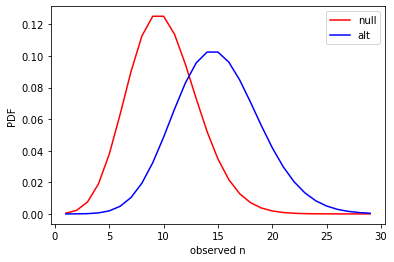

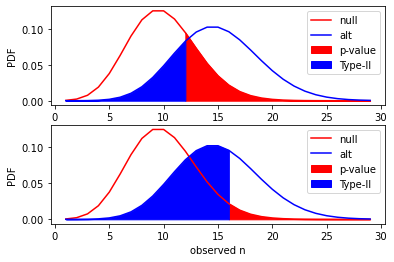

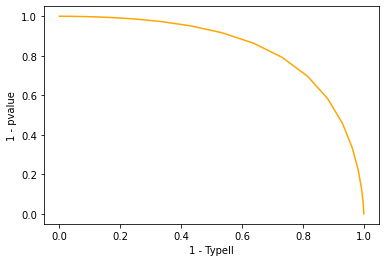

In [2]:
b = 10 # background of 10 events
s_null = 0 # the null hypothesis: no signal
s_alt  = 5 # the alternate hypothesis: 

ns = np.arange(1, 30, 1) # consider various observed values

# Compute the PDF values for the different n
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();

# A couple of plots illustrating different test sizes
plt.figure()
plt.subplot(211)
threshold1 = 12
lo1 = np.arange( 1, threshold1 + 1, 1)
hi1 = np.arange(threshold1, 30, 1)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.fill_between(hi1, scipy.stats.poisson.pmf(hi1, s_null + b), color='r', label='p-value')
plt.fill_between(lo1, scipy.stats.poisson.pmf(lo1, s_alt  + b), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();
#
plt.subplot(212)
threshold2 = 16
lo2 = np.arange( 1, threshold2 + 1, 1)
hi2 = np.arange(threshold2, 30, 1)
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null + b), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt  + b), color='b', label='alt')
plt.fill_between(hi2, scipy.stats.poisson.pmf(hi2, s_null + b), color='r', label='p-value')
plt.fill_between(lo2, scipy.stats.poisson.pmf(lo2, s_alt  + b), color='b', label='Type-II')
plt.xlabel('observed n')
plt.ylabel('PDF')
plt.legend();

# Now draw the ROC curve
thresholds = np.arange(1, 30, 1)
plt.figure()
plt.plot(scipy.stats.poisson.sf(thresholds, s_alt + b), scipy.stats.poisson.cdf(thresholds, s_null + b), color='orange')
plt.xlabel('1 - TypeII')
plt.ylabel('1 - pvalue')

 This is somewhat special situation, in which the entire measurement information is already contained in the single number $n$. In general this is not the case, and the observation consists of many quantities. We then need to condense the information into a single value, which nevertheless contains the maximal amount of information.

We investigate this in the context of a binned analysis, studied already in the previous lecture:

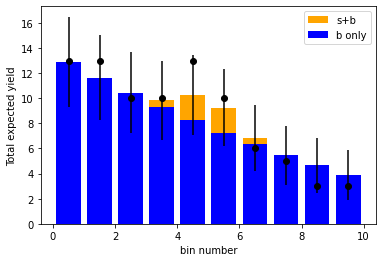

In [3]:
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)
# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_yields *= b_yields/np.sum(b_yields)
# The signal shape is a peak
s_yields = np.zeros(nbins)
s_yields[3:7] = [ 0.1, 0.4, 0.4, 0.1 ]
# Now generate some data
s = 5
b = 100
s_and_b = s*s_yields + b*b_yields
b_only = b*b_yields
np.random.seed(0) # make sure we always generate the same
data = [ np.random.poisson(s*s_yield + b*b_yield) for s_yield, b_yield in zip(s_yields, b_yields) ]
plt.bar(x, s_and_b, color='orange', yerr=np.sqrt(s_and_b), label='s+b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

We want to test $s = 0$ against $s = 5$. First, we try our previous technique: pick one bin, and perform the test in this bin only

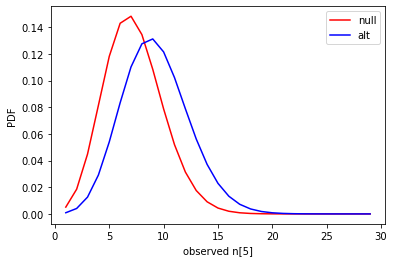

In [4]:
s_null = 0 # the null hypothesis: no signal
s_alt  = 5 # the alternate hypothesis: 
i_bin = 5  # test bin 5
ns = np.arange(1, 30, 1) # consider various observed values

# Compute the PDF values for the different n
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_null*s_yields[i_bin] + b*b_yields[i_bin]), color='r', label='null')
plt.plot(ns, scipy.stats.poisson.pmf(ns, s_alt*s_yields[i_bin] + b*b_yields[i_bin]), color='b', label='alt')
plt.xlabel('observed n[5]')
plt.ylabel('PDF')
plt.legend();

One can already see that this is not a good test: the distributions are stongly overlapping, and hard to separate. Let's draw the ROC curve:

Text(0, 0.5, '1 - pvalue')

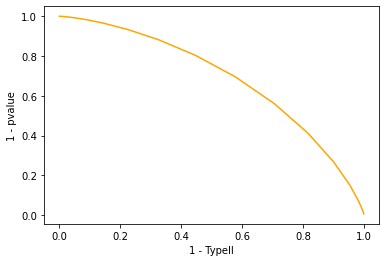

In [5]:
# Now draw the ROC curve
thresholds = np.arange(1, 30, 1)
plt.figure()
plt.plot(scipy.stats.poisson.sf(thresholds, s_alt*s_yields[i_bin] + b*b_yields[i_bin]), scipy.stats.poisson.cdf(thresholds, s_null*s_yields[i_bin] + b*b_yields[i_bin]), color='orange')
plt.xlabel('1 - TypeII')
plt.ylabel('1 - pvalue')

The curve looks perilously close to the diagonal, which corresponds to no sensitivity.

Now let's see if we can do better using the Neyman-Pearson theorem. It states that to separate $s_{\text{null}}$ from $s_{\text{alt}}$, the optimal discriminant is $L(s_{\text{null}})/L(s_{\text{alt}})$. We may as well take $-2\log$ of this as usual, so that our discriminant is
$$
t(s_{\text{null}}, s_{\text{alt}}) = -2 \log \frac{L(s_{\text{null}})}{L(s_{\text{alt}})}.
$$

Let's repeat our sensitivity studies with this new discriminant. First let's implement the discriminant:

In [6]:
def lambda_s(s_hypo, data) :
    return -2*sum( [ np.log(scipy.stats.poisson.pmf(n, s_hypo*s_yield + b*b_yield)) for n, s_yield, b_yield in zip(data, s_yields, b_yields) ] )


def log_L_ratio(data) :
    return lambda_s(s_null, data) - lambda_s(s_alt, data)

We can't plot the distributions of $t$ outright, since we don't know what distribution it follows (for the case of $n$, we knew from first principles that it followed a Poisson, but this is more complex).

So we'll simply generate these distributions by sampling: we will draw a large number of random datasets for $s = s_{\text{null}}$, make a histogram of the values of $t$, and this will provide its distribution for $s = s_{\text{null}}$. We can the repeat for $s = s_{\text{alt}}$ to make our plot.

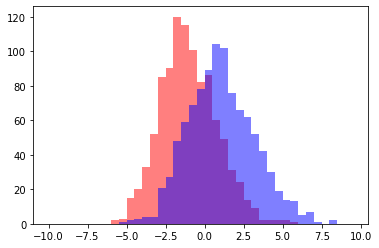

In [7]:
ndata = 1000

def generate_t_values(s_hypo, ndata = 1000) :
  t_values = []
  for k in range(0, ndata) :
    data = [ np.random.poisson(s_hypo*s_yield + b*b_yield) for s_yield, b_yield in zip(s_yields, b_yields) ]
    t_values.append(log_L_ratio(data))
  return t_values

hist_null = generate_t_values(s_null, ndata)
hist_alt  = generate_t_values(s_alt , ndata)
plt.hist(hist_null, color='red', alpha=0.5, bins=np.arange(-10,10,0.5));
plt.hist(hist_alt, color='blue', alpha=0.5, bins=np.arange(-10,10,0.5));

Now compute the ROC curve for the different cuts on the discriminant t(s)

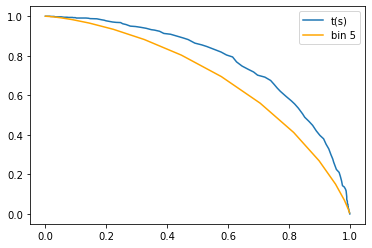

In [8]:
t_vals = np.arange(-10, 10, 0.1)
cdf_null = np.searchsorted(np.sort(hist_null), t_vals)/ndata
sf_alt = 1 - np.searchsorted(np.sort(hist_alt), t_vals)/ndata
plt.plot(sf_alt, cdf_null, label='t(s)')
plt.plot(scipy.stats.poisson.sf(thresholds, s_alt*s_yields[i_bin] + b*b_yields[i_bin]), scipy.stats.poisson.cdf(thresholds, s_null*s_yields[i_bin] + b*b_yields[i_bin]), color='orange', label='bin 5')
plt.legend();

The upshot of all this is that the likelihood ratio (LR) prescribed by the Neyman-Pearson lemma indeed seems better than bin 5 alone. This is not surprising, given that the LR accounts for all the bins, and assigns more weight to bins with more signal.

In the following, we will use the LR systematically when performing tests. We will also drop Type-II errors from the discussion, and focus only on the p-value (Type-I error rate). Since the LR is optimal anyway, we can do this and trust that the Type-II error rate is as low as can be.

## 2. Testing for discovery, using simple tools

First test we consider is *discovery* testing, i.e. testing for the presence of a signal. As an illustration, we can go back to a binned example:

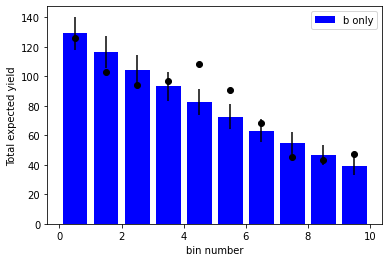

In [9]:
s = 70
b = 1000
s_and_b = s*s_yields + b*b_yields
b_only = b*b_yields
np.random.seed(1) # make sure we always generate the same
data = [ np.random.poisson(s*s_yield + b*b_yield) for s_yield, b_yield in zip(s_yields, b_yields) ]
plt.bar(x, b_only, yerr=np.sqrt(b_only), color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

Only the background is plotted, but we can ask the question of whether there is a signal present as well (seems so!). How do we test for this ?

To simplify matters, let's focus first on a single bin, say bin 4. The event counts are as follows:

In [10]:
b4 = b*b_yields[4]
print('n[4] =', data[4], ', b[4] =', b4)

n[4] = 108 , b[4] = 82.58064516129032


This implies that there is an amount of signal present that can be estimated as

In [11]:
s4 = data[4] - b4
print(s4)

25.41935483870968


This seems sizable, but it could well be due to a random fluctuation of the background. How do we tell ? We know that the typical size of the fluctuations is the RMS of the background yield, which is given by its square root:

In [12]:
sigma4 = np.sqrt(b4)
print(sigma4, s4/sigma4)

9.087389347953037 2.7972120336667943


So the observed signal is a bit less than 3 times the RMS : a bit larger than the typical fluctuation, but not huge either. How do we quantify how often such a fluctuation would happen ? Do do this, we can assume that the background count is distributed as Gaussian, with central value $b_4$ and width $\sqrt{b_4}$. How likely are we to see a fluctuation as large as the signal ?

For this, we just need to reuse the Gaussian quantile studies of the first lecture:

Text(0.5, 1.0, 'fraction (108)=0.00257728')

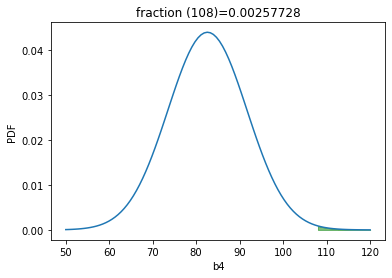

In [13]:
plot_b = np.linspace(50,120,100)
plt.plot(plot_b, scipy.stats.norm.pdf(plot_b, b4, np.sqrt(b4)))
plt.xlabel('b4')
plt.ylabel('PDF')

# Now fill in part of the distribution and print the integral
shaded_b = np.linspace(data[4], 120, 100)
plt.fill_between(shaded_b, scipy.stats.norm.pdf(shaded_b, b4, np.sqrt(b4)), alpha=0.5, color='g')
plt.title('fraction (%g)=%g' % (data[4], scipy.stats.norm.sf(data[4], b4, np.sqrt(b4))))

So a fluctuation at least as large as the signal should happen in only $0.3\%$ of cases. This is already a pretty good numerical indication, showing that it is not completely normal, but not quite rare either.

Recalling the previous section, one can see that this number is a p-value : it is the rate for a Type-I error (excluding the null although it is true). Small p-values mean good exclusion, and point towards discovery. High p-values (close to 1) point to good agreement with the null.

How small is small enough ? First, we need to introduce another measure of agreement. Recall the discussion of Gaussian tail probabilities from lecture 1:

In [14]:
bounds = [0, 1, 2, 3, 4, 5]
one_sided_tail = [ scipy.stats.norm.sf(up) for up in bounds ]

# Pretty-print the result
import pandas as pd
import jinja2
fields = np.array([ bounds, one_sided_tail ]).T
labels = [ 'Number of standard deviations from the mean', '1-sided tail fraction' ]
pd.DataFrame(fields, columns=labels)

,Number of standard deviations from the mean,1-sided tail fraction
0,0.0,5.000000e-01
1,1.0,1.586553e-01
2,2.0,2.275013e-02
3,3.0,1.349898e-03
4,4.0,3.167124e-05
5,5.0,2.866516e-07


These numbers are valid for any Gaussian, with the number of standard deviations defined as
$$
z = \frac{x - x_0}{\sigma}
$$
So we can express our p-value as a number of standard deviations. In our case, we already know that this is
$$
z = \frac{n_4 - b_4}{\sqrt{b_4}} = \frac{s_4}{\sqrt{b_4}}.
$$

This value is completely equivalent to the p-value, and one can go from one to the other using the table above.  It is called the *significance* of the signal. Significances are however easier to understand, and also usually easier to compute. In our case, we computed it already above:

In [15]:
z4 = s4/np.sqrt(b4)
print('z = ', z4)

z =  2.7972120336667943


and one can go from this to the p-value using the normal 1-CDF function:

In [16]:
p4 = scipy.stats.norm.sf(z4)
print(p4)

0.002577284673593357


Historically, thresholds for discoveries in physics have been defined in terms of the significance as follows:
* $z \ge 5$ : "real" discovery
* $z \ge 3$ : "evidence" for a signal -- suggestive but not quite at the threshold for a discovery
So in this context, our excess above is not significant as it doesn't even meet the $3\sigma$ threshold. To reach a $5\sigma$ discovery, we would have needed

In [17]:
print('s4 for discovery = ', 5*np.sqrt(b4))

s4 for discovery =  45.43694673976518


## 3. Discovery testing as a hypothesis test

Earlier in the lecture, we described statistics tests in terms of
* Definition of hypotheses (null and alternate)
* Definition of the discriminant
* Rate of Type-I errors (false positives), a.k.a. p-value and Type-II errors (false negatives)

The discovery setup we have just explored can be seen as exactly such a test. The parameters are as follows:
* Null: no signal; Alternate: any positive signal
* Discriminant: the likelihood ratio -- or in simple cases the measured yield.
* p-value: the tail integral seen above (false positive: probability to get an outcome that is larger than the threshold, even though the null is true)

We need to add one more element though: since the alternate can be *any* positive signal, how do we decide what value to use ? The natural solution is to use the best-fit value $\hat{s}$, so that the discriminant is finally
$$
t_0 = -2 \log \frac{L(s=0)}{L(\hat{s})}.
$$
the numerator is for the null, and uses $s=0$. The denominator uses $\hat{s}$ for the alternate.

First, let's check that this gives the same result as our previous determination, for a single bin counting. Recall that this is all for a Gaussian likelihood:
$$
L(s) = \exp\left[-\frac{1}{2} \left(\frac{(n - (s+b)}{\sqrt{s+b}}\right)^2 \right]
$$
First, what is the best-fit value $\hat{s}$ for a given $n$, the value that maximizes $L$ ? 



We need $\hat{s} = n - b$ so that $\hat{s}+b = n$

So what is the value of $t_0$ ?

$$
t_0 = \left(\frac{n - b}{\sqrt{b}}\right)^2
$$
It is equal to the square of the significance! In other words, once we have $t_0$, we can get the significance as
$$
z = \sqrt{t_0}
$$
and the p-value as

In [18]:
t0 = z4**2
scipy.stats.norm.sf(np.sqrt(t0))

0.002577284673593357

## 4. Testing for discovery in a histogram

Finally, let's apply all this to the full binned distribution above:

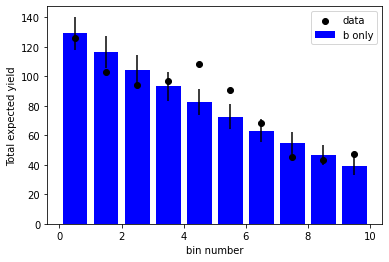

In [19]:
plt.bar(x, b_only, yerr=np.sqrt(b_only), color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

exact hat{s}: 53.59670474963077
11.672231033663309
z =  3.4164646981438733
p-value =  0.0003171994424167245


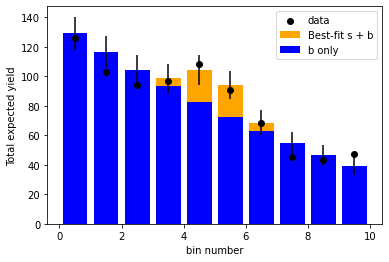

In [20]:
from scipy.optimize import minimize_scalar
s_hat = minimize_scalar(lambda s: lambda_s(s, data), (0, 200)).x
print('exact hat{s}:', s_hat)
t0 = lambda_s(0, data) - lambda_s(s_hat, data)
print(t0)
print('z = ', np.sqrt(t0))
print('p-value = ', scipy.stats.norm.sf(np.sqrt(t0)))
hats_plus_b = s_hat*s_yields + b_only
plt.bar(x, hats_plus_b, yerr=np.sqrt(hats_plus_b), color='orange', label='Best-fit s + b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

So the results are much better when looking at all the bins, rather than just bin 4 : overall we have a $>3\sigma$ result, which is evidence for the signal.